### Installation

In [4]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineG

In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    !pip install transformers==4.51.3
    !pip install --no-deps unsloth

### Unsloth

In [2]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.6.1: Fast Mllama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [3]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.vision_model.transformer` require gradients


## Data Prep
We'll be using the [ConstructionSite](https://huggingface.co/datasets/LouisChen15/ConstructionSite) dataset, which contains annotated construction site images focused on safety and site condition analysis.

The goal is to finetune a Vision-Language Model (VLM) to generate professional site inspection captions or reports, enabling it to support civil engineers, site managers, and safety auditors in analyzing construction progress, compliance, and manpower deployment directly from visual inputs.

In [5]:
from datasets import load_dataset

dataset = load_dataset("LouisChen15/ConstructionSite", split="train")

Let's take a look at the dataset, and check what the 1st example shows:

In [6]:
dataset

Dataset({
    features: ['image', 'image_id', 'image_caption', 'illumination', 'camera_distance', 'view', 'quality_of_info', 'rule_1_violation', 'rule_2_violation', 'rule_3_violation', 'rule_4_violation', 'excavator', 'rebar', 'worker_with_white_hard_hat'],
    num_rows: 7009
})

In [7]:
dataset[1]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1200x900>,
 'image_id': '0004851',
 'image_caption': 'The excavator is positioned in the center, actively digging into the earth with its bucket. The operator is visible inside the cabin of the excavator. In the background, there is an embankment and buildings under construction.',
 'illumination': 'normal lighting',
 'camera_distance': 'short distance',
 'view': 'elevation view',
 'quality_of_info': 'poor info',
 'rule_1_violation': None,
 'rule_2_violation': None,
 'rule_3_violation': {'bounding_box': [[0.04, 0.16, 0.86, 0.29]],
  'reason': 'The excavation edge in the background is not protected.'},
 'rule_4_violation': None,
 'excavator': [[0.15, 0.37, 0.85, 0.92]],
 'rebar': [],
 'worker_with_white_hard_hat': []}

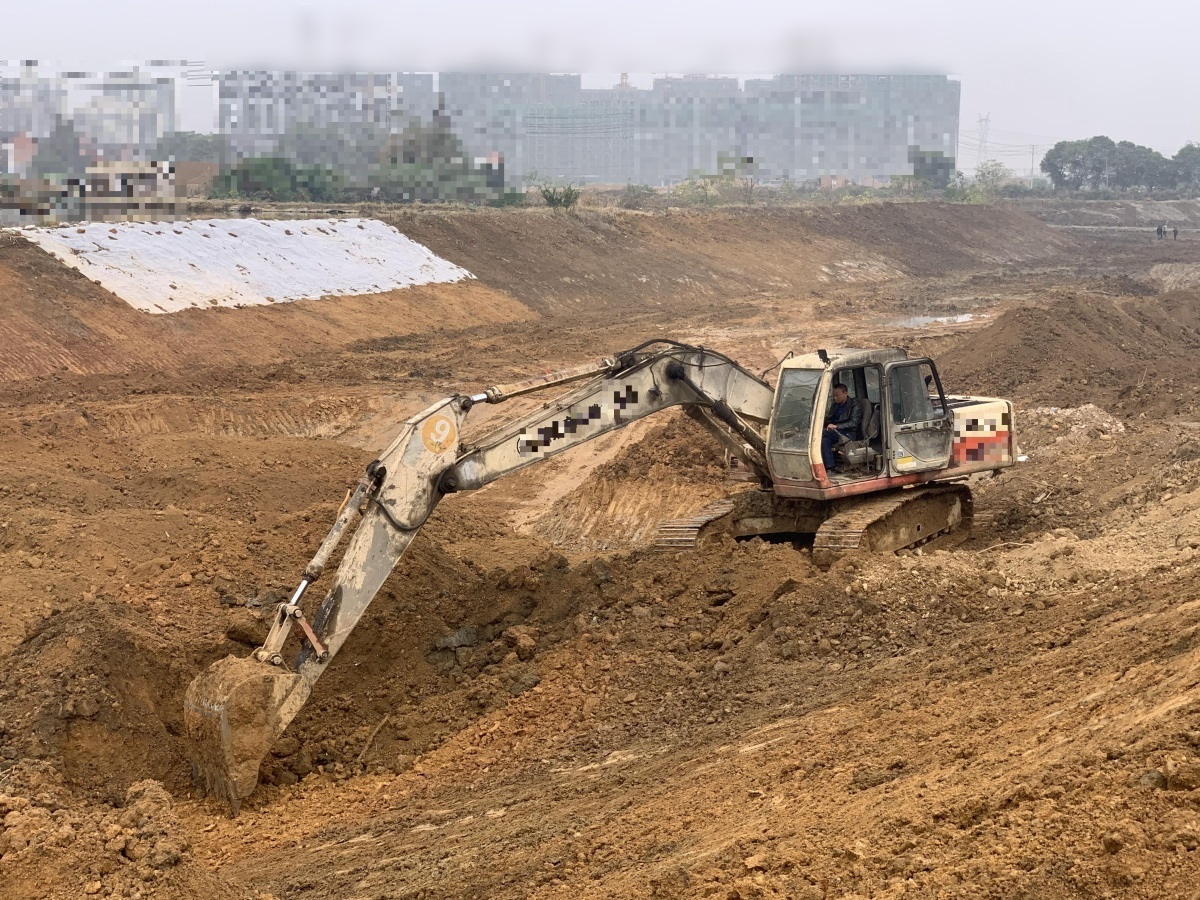

In [8]:
dataset[1]["image"]

In [9]:
dataset[1]["image_caption"]

'The excavator is positioned in the center, actively digging into the earth with its bucket. The operator is visible inside the cabin of the excavator. In the background, there is an embankment and buildings under construction.'

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": instruction}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": answer} ]
},
]
```

You are a professional civil site engineer or construction supervisor with hands-on experience managing daily site work, labor deployment, and progress tracking. You prepare daily construction reports for stakeholders, summarizing work completed, materials used, manpower, site conditions, and any issues or delays.

Let's convert the dataset into the "correct" format for finetuning:

In [10]:
instruction = (
    "You are a construction supervisor. Based on the image, write a daily site progress"
)

def convert_to_conversation(sample):
    img_field = sample["image"]
    image_input = img_field["path"] if isinstance(img_field, dict) and "path" in img_field else img_field

    return {
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text",  "text": instruction},
                    {"type": "image", "image": image_input}
                ]
            },
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": sample["image_caption"]}
                ]
            }
        ]
    }


def convert_dataset_in_batches(dataset, batch_size=500):
    from tqdm import tqdm
    all_batches = []
    for i in tqdm(range(0, len(dataset), batch_size), desc="Processing Batches"):
        batch = dataset.select(range(i, min(i + batch_size, len(dataset))))
        batch_dict = batch.to_dict()
        # transpose columns to list of row-dicts
        batch_list = [
            dict(zip(batch_dict.keys(), values))
            for values in zip(*batch_dict.values())
        ]
        # convert each sample
        converted = [convert_to_conversation(sample) for sample in batch_list]
        all_batches.extend(converted)
    return all_batches

# Now this won’t embed raw bytes as text:
converted_dataset = convert_dataset_in_batches(dataset, batch_size=200)


Processing Batches: 100%|██████████| 36/36 [00:15<00:00,  2.37it/s]


The first example is now structured like below:

In [11]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'You are a construction supervisor. Based on the image, write a daily site progress'},
    {'type': 'image', 'image': '0004850.jpg'}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'The image shows three workers with yellow hard hats, engaged in tasks related to reinforcing steel bars at a construction site. One worker is bending over the rebar framework, while the other is handling large curved segments of material. A yellow excavator is visible in the background on the left, while the third worker is standing at the back of it.'}]}]}

Before we do any finetuning, maybe the vision model already knows how to analyse the images? Let's check if this is the case!

In [12]:
FastVisionModel.for_inference(model)

image = dataset[0]["image"]

instruction = (
    "You are a construction supervisor. Based on the image, write a daily site progress"
)

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=256,
    temperature=0.7,
    top_p=0.9,
    use_cache=True
)


**Daily Site Progress Report**

**Date:** [Insert Date]

**Site Name:** [Insert Site Name]

**Location:** [Insert Location]

**Weather Conditions:** Clear, sunny with a high of 22°C and a low of 15°C.

**Workforce:** 25 workers present on site today.

**Progress:**

* Foundation work: The foundation team has completed 60% of the excavation work for the new building. Reinforcement steel has been laid out and is ready for concrete pouring.
* Concrete work: The concrete crew has poured 40% of the foundation concrete. The quality of the concrete is satisfactory.
* Steel erection: The steel erector has erected 50% of the steel structure. The structure is on schedule and meets the required specifications.
* Electrical work: The electrician has completed 20% of the electrical wiring. The wiring is in accordance with the approved plans.

**Issues and Concerns:**

* The foundation excavation has encountered some rock formations that require additional support. The team is working on a plan to a

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [13]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

In [14]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
8.562 GB of memory reserved.


In [15]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 7,009 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 67,174,400/11,000,000,000 (0.61% trained)


FileNotFoundError: [Errno 2] No such file or directory: '0009842.jpg'

In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# # Select ONLY 1 to save! (Both not needed!)

# # Save locally to 16bit
# if False: model.save_pretrained_merged("unsloth_finetune", tokenizer,)

# # To export and save to your Hugging Face account
# if False: model.push_to_hub_merged("YOUR_USERNAME/unsloth_finetune", tokenizer, token = "PUT_HERE")